In [1]:
#clustering hw
import geopandas as gpd
import numpy as np
import pysal as ps
import pandas as pd
import os
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
#test=os.getenv ('PUI2015')+'/hw10'+'/test/test.txt'
#with open(test,'r+') as testfile:
#    print testfile.readline()

IOError: [Errno 2] No such file or directory: '~/Documents/CUSP/Semester_1/1_PUI/Homework/hw10/test/test.txt'

In [25]:
#Data:
np.random.seed(2015)
import zipfile

years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
         '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
for i in years:
    fname = 'zbp'+i+'totals.zip'
    zf = zipfile.ZipFile(fname)
    name = 'df'+i
    myfile = zf.open('zbp'+i+'totals.txt')
    globals()[name] = pd.read_csv(myfile)

In [26]:
#geodata = gpd.read_file(os.getenv ('PUI2015')+
 #                       '/nyc-zip-code-tabulation-areas-polygons.geojson')
geo = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

### Munging

In [27]:
geo['zip'] = geo['postalCode']
geodt= pd.DataFrame({'zip':geo['zip'].astype(float)}).drop_duplicates()
geodt.head()
finaldf = geodt

In [29]:
for i in years:
    #array = 'data'+i
    name='df'+ i 
    dataframe = globals()[name]
    dataframe.head()
    if i == '98' or i == '99' or i == '00' or i == '01' or i == '02':
        dataframe = dataframe[['ZIP','EST']]
        dataframe.columns = ['zip', 'est'+i]
        newdf = pd.merge(geodt,dataframe, on = 'zip')
    else:
        dataframe = dataframe[['zip', 'est']]
        dataframe.columns = ['zip', 'est'+i]  
        newdf = pd.merge(geodt,dataframe, on = 'zip')
        
    finaldf['est'+i] = newdf['est'+i]
    #finaldf.head()
    #shape(finaldf)

(247, 21)

In [16]:
#Converting to array
est_time_array = finaldf.as_matrix()

#Removing NaN
badindex = []
for i,est in enumerate(est_time_array):
    if np.isnan(est).any():
        badindex.append(i)
        
clean_array = np.delete(est_time_array, badindex, 0)

np.shape(clean_array)

(224L, 21L)

In [17]:
zips=[]
for i in range(224):
    new = clean_array[i][1:]
    zips.append(clean_array[i][0])
    array_mean = np.mean(new)
    array_std = np.std(new)
    for i in range(len(new)):
        new[i] = (new[i]-array_mean)/array_std
    clean_array[i][1:] = new

### Plotting the array

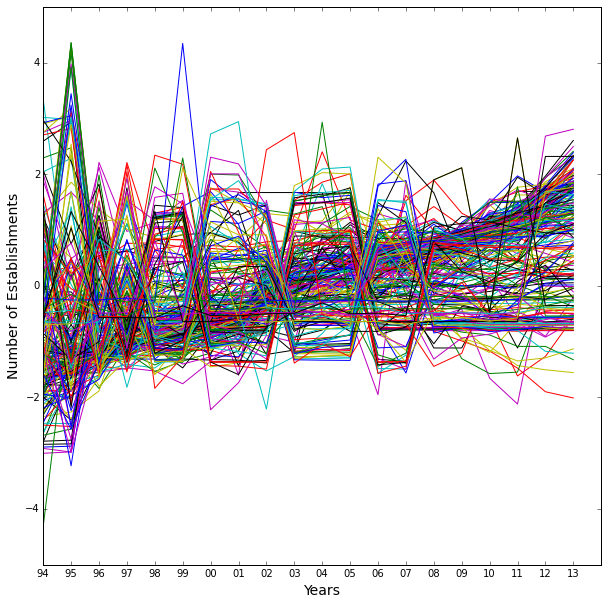

In [18]:
plt.figure(figsize=(10, 10), dpi=200)
#Make a list to have all data but not zip code
s = []
for i in range(224):
    ax = plt.plot(range(20), clean_array[i][1:])
    s.append(clean_array[i][1:])
    
plt.ylabel('Number of Establishments', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.xticks(range(20), years);
s=np.array(s)

                 Plot of the different time series after normalization

### K-Means Clustering

C:\Users\Alan\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


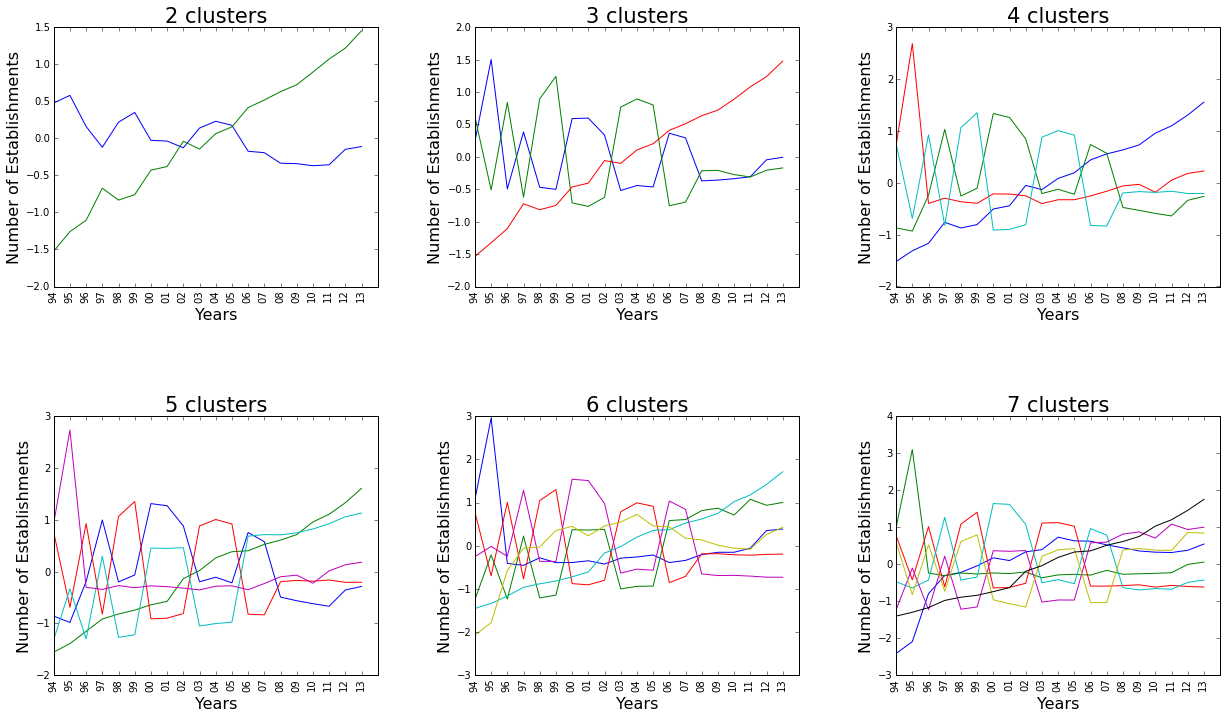

In [19]:
from sklearn.cluster import k_means
plt.figure(figsize=(18, 18), dpi=200)
p = 1
for i in range(6):
    n = i+2
    est=k_means(s,n_clusters = n)
    plt.subplot(2, 3, p)
    p += 1
    plt.plot(range(20), transpose(est[0]))
    plt.title(str(n)+' clusters', fontsize = 21)
    plt.ylabel('Number of Establishments', fontsize = 16)
    plt.xlabel('Years', fontsize = 16)
    plt.xticks(range(20), years, rotation = 90);
    plt.legend()
plt.subplots_adjust(wspace=.3, hspace=0.5, left=0, right=0.9, top=0.5, bottom=0)

                                 Plots of the centroids of the various clusters using K-means

#### The best clustering seems to be 4 to 6 clusters where most of the different patterns are captured.

Further the clustering of 5 will be used.

In [20]:
#Making a dataframe to use for mapping  
with_zip=pd.DataFrame()
with_zip['zip']=zips

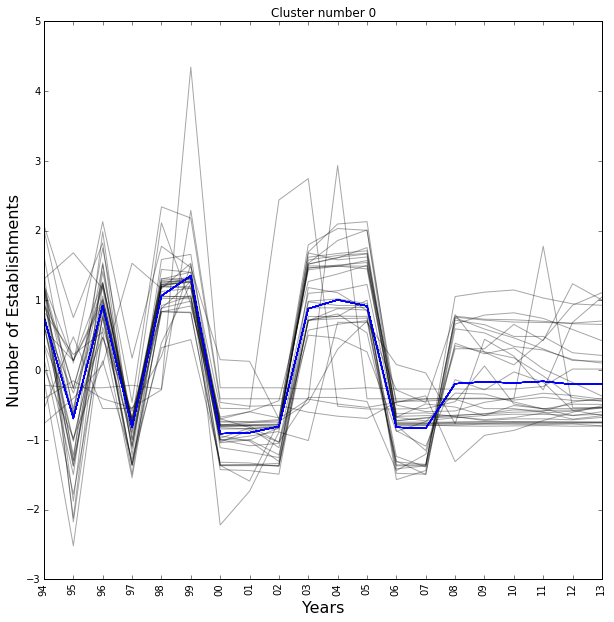

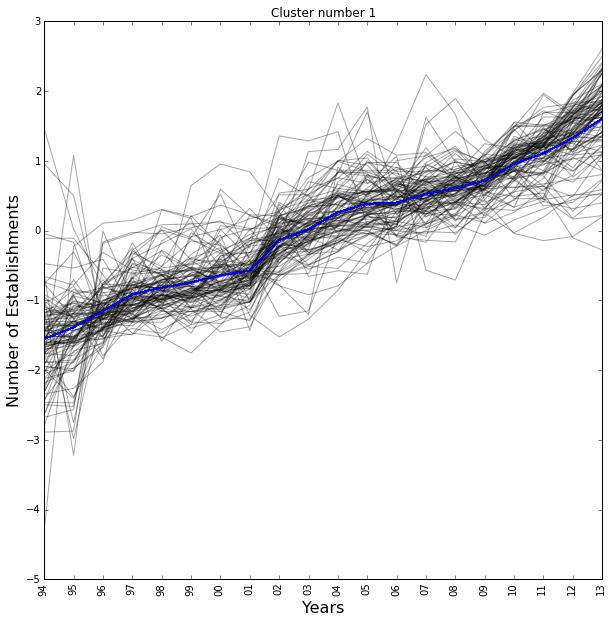

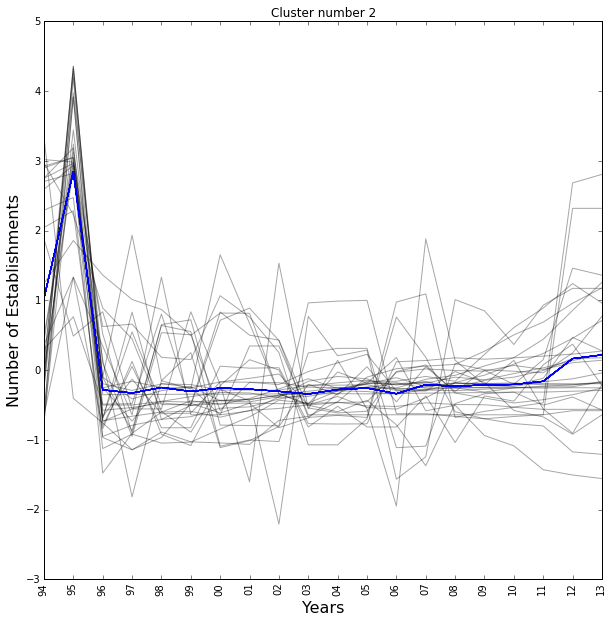

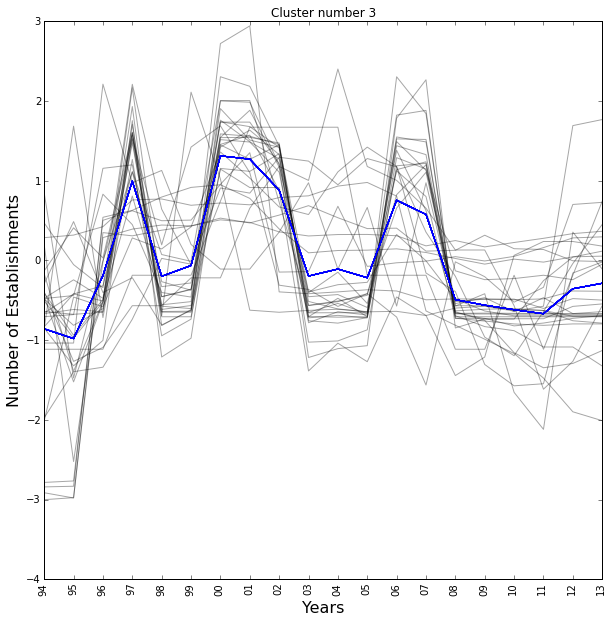

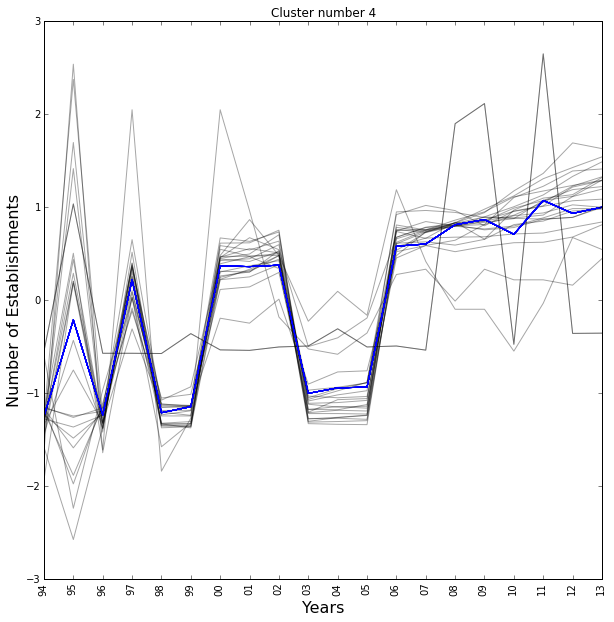

In [21]:
est = k_means(s,n_clusters=5)
with_zip['cluster'] = est[1]
for m in range(5):
    i = 0
    fig0 = plt.figure(figsize=(10,10));
    ax0 = fig0.add_subplot(1,1,1);
    for j in est[1]:
        if j==m:
            ax0.plot(range(20),s[i],c='k', alpha = 0.35)
            ax0.plot(range(20),est[0][j],c='b')
            plt.title('Cluster number ' + str(m))
            plt.ylabel('Number of Establishments', fontsize = 16)
            plt.xlabel('Years', fontsize = 16)
            plt.xticks(range(20), years, rotation = 90);
        i = i+1      

                 Plots of each cluster with its comprising timeseries

### Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5, compute_full_tree=True).fit(s)

In [23]:
with_zip['cluster2']=agc.labels_

### Mapping

In [30]:
#Putting the clusters into a geodataframe
geo['zip'] = geo['postalCode'].astype(float)
clusters = geo.join(with_zip,rsuffix='zip',how='inner')

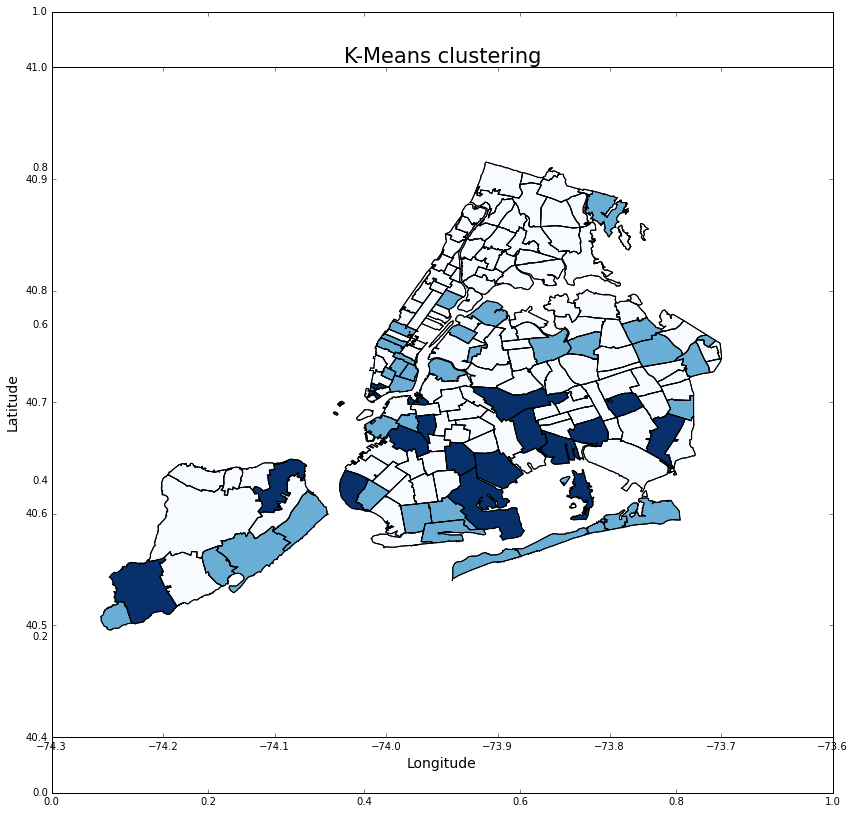

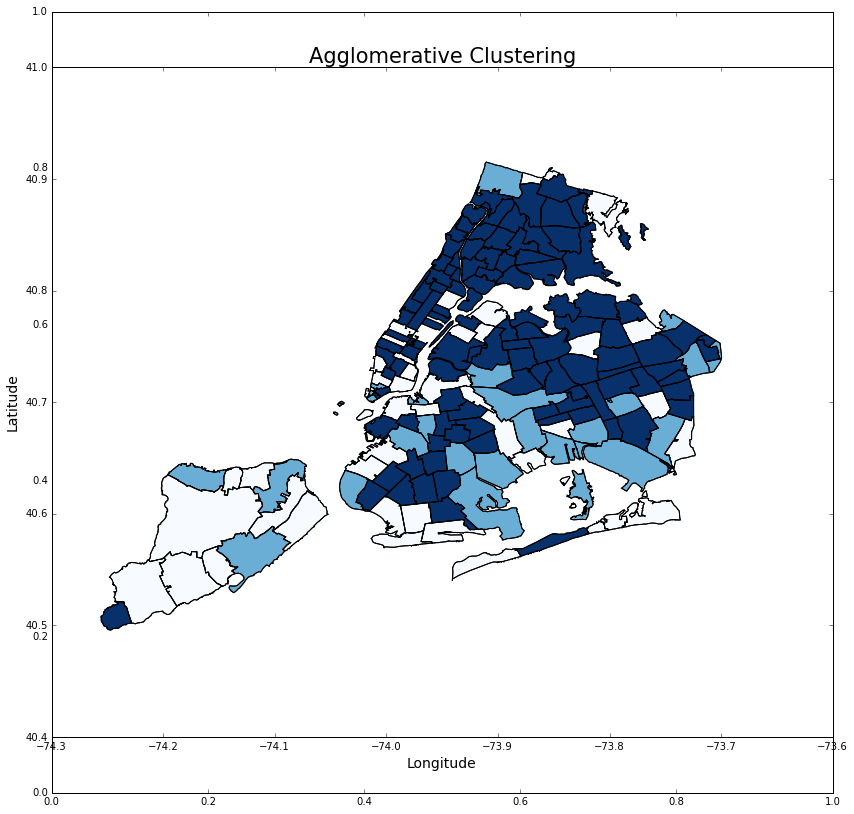

In [31]:
f, ax = plt.subplots(1, figsize=(14,14))
clusters.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='Blues')
plt.title('K-Means clustering', fontsize = 21)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)
f2, ax2 = plt.subplots(1, figsize=(14,14))
clusters.plot(column='cluster2', scheme='QUANTILES', alpha=1, colormap='Blues')
plt.title('Agglomerative Clustering',fontsize = 21)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)

                      Map of the two different clustering algorithms for comparison

### Discussion

K-Means:

1. Much of Staten Island and white areas between Brooklyn and Queens showed an upward trend
2. Areas around Prospect Park, Upper Manhattan, Bronx and Queens (light blue areas) show a steady increase in number of establishments, perhaps pinting to gentrification of the area
3. Some parts of each borough (dark blue areas) have shown a peak in the past but now have almost no establishments - perhaps pointing to neighborhood change again.

From Agglomerative:

1. It shows clusters similar to K-Means with differences around Long Island and Brooklyn. 

2. I dont know which algo clusters better.